In [205]:
import pandas as pd
import os
import glob
import numpy as np
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker
from math import isnan

from nilearn import datasets

data_dir = None # change this variable with the path where you want nilearn to download
                # the data, if you leave None, the default will be '~/nilearn_data'
    
# Loading the functional datasets
data = datasets.fetch_development_fmri(n_subjects=1, data_dir=data_dir)

# you can use the .keys() method to check what's in the dataset
data.keys()
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiMasker

### Atlas

atlas_dataset = datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_filepath = atlas_dataset.maps
labels = atlas_dataset.labels

### Atlas Yeo 2011

atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011(data_dir=data_dir)
yeo_2011_filepath = atlas_yeo_2011.thick_7


### Atlas Yeo 2018

atlas_yeo_2018 = datasets.fetch_atlas_schaefer_2018(n_rois = 100, yeo_networks = 7, data_dir=data_dir)
yeo_2018_filepath = atlas_yeo_2018.maps
yeo_2018_labels = atlas_yeo_2018.labels

### Fonctions

###selectionne la run avec la framewise_displacement moyenne la plus faible pour un sujet donné
def less_motion(path_subj):  
    dic = {}
    res = 0
    mini = float("inf")
    liste_tsv=glob.glob('{}/*/*/*timeseries.tsv'.format(path_subj))
    for i in liste_tsv:
        dic[i] = pd.read_csv(i, sep='\t')
    for k in dic:
        moy = dic[k]['framewise_displacement'].mean()
        if moy < mini:
            mini = moy
            run = k
            df = dic[k]
            bold = "{}space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz".format(run[0:-29])
    return bold, mini


def make_connectome(fmri_filepath): ### création du connectome
    confounds_ica, sample_mask = load_confounds(    ### gestion des confounds
        fmri_filepath,
        strategy=["high_pass", "motion", "wm_csf", "ica_aroma"],
        motion="basic", wm_csf="basic", ica_aroma="full")

    atlas_masker = NiftiLabelsMasker(labels_img=yeo_2011_filepath, standardize=True)
    data_in_atlas = atlas_masker.fit_transform(fmri_filepath, confounds=confounds_ica)
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]
    
    return correlation_matrix

def plot_matrix(matrix):  ### affiche la matrice de correlation
    # Make a large figure
    # Mask the main diagonal for visualization:
    np.fill_diagonal(matrix, 0)
    # The matrix is reordered for block-like representation
    plotting.plot_matrix(matrix, figure=(10, 8),
                     vmax=0.8, vmin=-0.8, reorder=False,labels = yeo_2011_labels, title = "{}".format(i))

### retourne une liste de chemin vers les sujets    
def create_path_subj(list_subj): 
    list_path = []
    for i in list_subj:
        list_path.append('{}/sub-{}'.format(path, i))
    return list_path

### retourne un dictionnaire comportant la meilleure run pour chaque sujet
def create_dictbold_motionless(list_path):    
    dict_bold_motionless = {}
    dict_fw = {}
    for sub in list_path:
        dict_bold_motionless[sub[-8:]], dict_fw[sub[-8:]] = less_motion(path_subj = sub)
    return dict_bold_motionless, dict_fw

### retourne un dictionnaire associant chaque sujet à son connectome
def create_dict_connectome(dict_bold_motionless):
    dict_connectome = {}
    for i in dict_bold_motionless:
        dict_connectome[i] = make_connectome(dict_bold_motionless[i])
    return dict_connectome

In [206]:
df_participants = pd.read_excel("/home/pierre/Documents/participants-func.xlsx")
df_participants = df_participants.set_index('participant_id')
df_participants.index



Index(['sub-0003', 'sub-0023', 'sub-0070', 'sub-0095', 'sub-0096', 'sub-0114',
       'sub-0132', 'sub-0178', 'sub-0182', 'sub-0183',
       ...
       'sub-1364', 'sub-1374', 'sub-1376', 'sub-1387', 'sub-1398', 'sub-1401',
       'sub-1411', 'sub-1425', 'sub-1460', 'sub-1491'],
      dtype='object', name='participant_id', length=440)

In [207]:
df_participants_complet = pd.read_csv("/home/pierre/Documents/participants.csv", sep = "\t", keep_default_na = False)
df_participants_complet = df_participants_complet.set_index('participant_id')
df_participants_complet.index

Index(['sub-0001', 'sub-0002', 'sub-0003', 'sub-0004', 'sub-0005', 'sub-0006',
       'sub-0007', 'sub-0008', 'sub-0009', 'sub-0010',
       ...
       'sub-1548', 'sub-1550', 'sub-1551', 'sub-1552', 'sub-1553', 'sub-1554',
       'sub-1555', 'sub-1556', 'sub-1557', 'sub-1558'],
      dtype='object', name='participant_id', length=1450)

In [208]:
#list_fwd_ban = ['0114', '0216', '0243', '0271', '0298', '0398', '0413', '0420', '0440', '0453', '0460', '0530', '0576', '0790', '0879', '0911', '1311', '1317', '1364', '1398']

In [209]:
path = "/home/pierre/Documents/export/iso+tfe+st"

liste_path_sub = glob.glob('{}/sub*/'.format(path))
liste_path_sub = sorted(liste_path_sub)

banlist = []
for i in liste_path_sub:
    if not glob.glob("{}/*/func/*bold.nii.gz".format(i)):
        banlist.append(i[-5:-1])
other_ban = ['0200', '0023', '0178', '0373']
for i in other_ban:
    banlist.append(i)
banlist = banlist
print(banlist)



['0220', '0237', '0287', '0303', '0360', '0386', '0454', '0456', '0495', '0531', '0581', '0743', '0776', '0864', '0866', '0912', '0936', '1215', '1401', '0200', '0023', '0178', '0373']


In [210]:
liste_sub = []
j = 0
maxi = 500
last = "0000"
for i in liste_path_sub:
    if j < maxi and i[-5:-1] > last and i[-5:-1] not in banlist and i[-9:-1] in df_participants.index:
        liste_sub.append(i[-5:-1])
        j = j+1
        
liste_y = liste_sub

liste_y_comp = []
for i in liste_y:
    liste_y_comp.append("sub-{}".format(i))

liste_path_y = create_path_subj(liste_y)
dict_bold_motionless_y, dict_fw_y = create_dictbold_motionless(liste_path_y)

In [211]:
for i in dict_fw_y:
    if dict_fw_y[i] > 0.5:
        print(i)

sub-0114
sub-0216
sub-0243
sub-0271
sub-0298
sub-0398
sub-0413
sub-0420
sub-0440
sub-0453
sub-0460
sub-0530
sub-0576
sub-0790
sub-0879
sub-0911
sub-1311
sub-1317
sub-1364
sub-1398


In [212]:
import pickle

with open("connectome_iso+tfe+st.pkl", "rb") as tf:
    dict_connectome_y = pickle.load(tf)

print(len(dict_connectome_y))

418


In [213]:
dict_connectome_y['sub-0003']

array([[0.        , 0.8103658 , 0.7686732 , 0.7450342 , 0.3603352 ,
        0.7366579 , 0.82835686],
       [0.8103658 , 0.        , 0.7688731 , 0.91583854, 0.30068088,
        0.73323905, 0.80746824],
       [0.7686732 , 0.7688731 , 0.        , 0.72248924, 0.22595407,
        0.85349137, 0.8183684 ],
       [0.7450342 , 0.91583854, 0.72248924, 0.        , 0.38160664,
        0.76176304, 0.80932415],
       [0.3603352 , 0.30068088, 0.22595407, 0.38160664, 0.        ,
        0.31728107, 0.39220077],
       [0.7366579 , 0.73323905, 0.85349137, 0.76176304, 0.31728107,
        0.        , 0.86054486],
       [0.82835686, 0.80746824, 0.8183684 , 0.80932415, 0.39220077,
        0.86054486, 0.        ]], dtype=float32)

In [214]:
yeo_2011_labels = ['Networks_1','Networks_2','Networks_3','Networks_4','Networks_5','Networks_6','Networks_7']
#for i in dict_connectome_x:
    #plot_matrix(dict_connectome_x[i])

In [215]:
liste_moyenne = []
for i in dict_connectome_y:
    new_list = []
    for j in range(len(dict_connectome_y[i])):
        new_list.append(dict_connectome_y[i][j].mean())
    liste_moyenne.append(new_list)
        

In [216]:
print(liste_moyenne)

[[0.60706043, 0.6194951, 0.59397846, 0.61943656, 0.2825798, 0.60899675, 0.6451805], [0.09126229, 0.41865873, 0.36308193, 0.3653036, 0.31157017, 0.4339206, 0.35642576], [0.2602681, 0.27367657, 0.26285475, 0.30725628, 0.19886719, 0.24906138, 0.12364455], [0.51062685, 0.5839537, 0.58459157, 0.6047021, 0.3258057, 0.6069389, 0.6324314], [0.6675152, 0.6453429, 0.64297473, 0.6727124, 0.42137703, 0.6852785, 0.6653091], [0.4112198, 0.45959467, 0.51113874, 0.41445807, 0.2423133, 0.52157915, 0.361661], [0.63618994, 0.69811064, 0.7104326, 0.7011663, 0.60591704, 0.7074266, 0.66735446], [0.5106657, 0.44717497, 0.5112191, 0.4082649, 0.3595632, 0.45991915, 0.46877727], [0.47738737, 0.38887173, 0.48780498, 0.48858503, 0.1437877, 0.52163434, 0.44839826], [0.22462845, 0.11801375, 0.28011754, 0.22608218, 0.06550077, 0.26271537, 0.20070896], [0.5141792, 0.5898286, 0.6463359, 0.6036638, 0.3398141, 0.59461176, 0.5854439], [0.30566162, 0.3677082, 0.39997134, 0.34559923, -0.17166008, 0.3667333, 0.3264725], [0.

In [217]:
columns = dict_connectome_y.keys()
index = yeo_2011_labels

In [218]:
df = pd.DataFrame(data = liste_moyenne, index = columns, columns = index)

In [219]:
df

Networks_1  Networks_2  Networks_3  Networks_4  Networks_5  \
sub-0003    0.607060    0.619495    0.593978    0.619437    0.282580   
sub-0070    0.091262    0.418659    0.363082    0.365304    0.311570   
sub-0095    0.260268    0.273677    0.262855    0.307256    0.198867   
sub-0096    0.510627    0.583954    0.584592    0.604702    0.325806   
sub-0114    0.667515    0.645343    0.642975    0.672712    0.421377   
...              ...         ...         ...         ...         ...   
sub-1398    0.457721    0.485026    0.499344    0.559456    0.394192   
sub-1411    0.517455    0.468732    0.490194    0.465684    0.325368   
sub-1425    0.225423    0.142260    0.291273    0.241624    0.172067   
sub-1460    0.403123    0.481765    0.363352    0.448964    0.288513   
sub-1491    0.469830    0.411836    0.339480    0.333819    0.367710   

          Networks_6  Networks_7  
sub-0003    0.608997    0.645181  
sub-0070    0.433921    0.356426  
sub-0095    0.249061    0.123645  
sub-0096    0.606939    0.632431  
sub-0114    0.685278    0.665309  
...              ...         ...  
sub-1398    0.527718    0.555176  
sub-1411    0.427246    0.409212  
sub-1425    0.264931    0.238509  
sub-1460    0.456637    0.439163  
sub-1491    0.484650    0.348060  

[418 rows x 7 columns]

In [220]:
cols = list(df.columns)

In [221]:
df[cols]

Networks_1  Networks_2  Networks_3  Networks_4  Networks_5  \
sub-0003    0.607060    0.619495    0.593978    0.619437    0.282580   
sub-0070    0.091262    0.418659    0.363082    0.365304    0.311570   
sub-0095    0.260268    0.273677    0.262855    0.307256    0.198867   
sub-0096    0.510627    0.583954    0.584592    0.604702    0.325806   
sub-0114    0.667515    0.645343    0.642975    0.672712    0.421377   
...              ...         ...         ...         ...         ...   
sub-1398    0.457721    0.485026    0.499344    0.559456    0.394192   
sub-1411    0.517455    0.468732    0.490194    0.465684    0.325368   
sub-1425    0.225423    0.142260    0.291273    0.241624    0.172067   
sub-1460    0.403123    0.481765    0.363352    0.448964    0.288513   
sub-1491    0.469830    0.411836    0.339480    0.333819    0.367710   

          Networks_6  Networks_7  
sub-0003    0.608997    0.645181  
sub-0070    0.433921    0.356426  
sub-0095    0.249061    0.123645  
sub-0096    0.606939    0.632431  
sub-0114    0.685278    0.665309  
...              ...         ...  
sub-1398    0.527718    0.555176  
sub-1411    0.427246    0.409212  
sub-1425    0.264931    0.238509  
sub-1460    0.456637    0.439163  
sub-1491    0.484650    0.348060  

[418 rows x 7 columns]

In [222]:
for col in cols:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    df = df.drop([col], axis = 1)
df

Networks_1_zscore  Networks_2_zscore  Networks_3_zscore  \
sub-0003           1.576194           1.401931           1.043711   
sub-0070          -2.215558          -0.111403          -0.760900   
sub-0095          -0.973157          -1.203866          -1.544243   
sub-0096           0.867289           1.134121           0.970346   
sub-0114           2.020612           1.596698           1.426650   
...                     ...                ...                ...   
sub-1398           0.478369           0.388683           0.304082   
sub-1411           0.917486           0.265909           0.232563   
sub-1425          -1.229309          -2.194113          -1.322137   
sub-1460           0.077000           0.364112          -0.758786   
sub-1491           0.567382          -0.162809          -0.945369   

          Networks_4_zscore  Networks_5_zscore  Networks_6_zscore  \
sub-0003           1.397608          -0.206329           1.278557   
sub-0070          -0.520721          -0.013583          -0.087345   
sub-0095          -0.958892          -0.762904          -1.529572   
sub-0096           1.286384           0.081064           1.262502   
sub-0114           1.799762           0.716482           1.873689   
...                     ...                ...                ...   
sub-1398           0.944847           0.535741           0.644440   
sub-1411           0.237002           0.078154          -0.139415   
sub-1425          -1.454318          -0.941090          -1.405760   
sub-1460           0.110794          -0.166884           0.089882   
sub-1491          -0.758381           0.359672           0.308435   

          Networks_7_zscore  
sub-0003           1.603263  
sub-0070          -0.253461  
sub-0095          -1.750268  
sub-0096           1.521285  
sub-0114           1.732692  
...                     ...  
sub-1398           1.024524  
sub-1411           0.085962  
sub-1425          -1.011677  
sub-1460           0.278549  
sub-1491          -0.307253  

[418 rows x 7 columns]

In [223]:
df_t = df.T
df_t

sub-0003  sub-0070  sub-0095  sub-0096  sub-0114  sub-0132  \
Networks_1_zscore  1.576194 -2.215558 -0.973157  0.867289  2.020612  0.136524   
Networks_2_zscore  1.401931 -0.111403 -1.203866  1.134121  1.596698  0.197056   
Networks_3_zscore  1.043711 -0.760900 -1.544243  0.970346  1.426650  0.396263   
Networks_4_zscore  1.397608 -0.520721 -0.958892  1.286384  1.799762 -0.149677   
Networks_5_zscore -0.206329 -0.013583 -0.762904  0.081064  0.716482 -0.474047   
Networks_6_zscore  1.278557 -0.087345 -1.529572  1.262502  1.873689  0.596546   
Networks_7_zscore  1.603263 -0.253461 -1.750268  1.521285  1.732692 -0.219798   

                   sub-0182  sub-0183  sub-0184  sub-0185  ...  sub-1354  \
Networks_1_zscore  1.790332  0.867574  0.622937 -1.235152  ... -1.346451   
Networks_2_zscore  1.994312  0.103472 -0.335852 -2.376810  ... -1.600964   
Networks_3_zscore  1.953879  0.396891  0.213894 -1.409323  ... -1.401433   
Networks_4_zscore  2.014546 -0.196426  0.409872 -1.571637  ... -0.750546   
Networks_5_zscore  1.943421  0.305505 -1.129107 -1.649608  ... -0.025128   
Networks_6_zscore  2.046483  0.115490  0.596977 -1.423046  ... -0.729056   
Networks_7_zscore  1.745844  0.468971  0.337932 -1.254736  ... -0.652685   

                   sub-1364  sub-1374  sub-1376  sub-1387  sub-1398  sub-1411  \
Networks_1_zscore  0.690043 -1.960631 -0.548260 -0.920532  0.478369  0.917486   
Networks_2_zscore  1.544231 -1.778970 -0.086006 -1.880430  0.388683  0.265909   
Networks_3_zscore  0.880728 -1.480607 -0.270054 -1.911087  0.304082  0.232563   
Networks_4_zscore  1.392049 -2.033496 -0.710565 -1.310443  0.944847  0.237002   
Networks_5_zscore  1.438002 -0.456668  0.162135 -0.866324  0.535741  0.078154   
Networks_6_zscore  1.697191 -1.786988  0.010760 -1.189110  0.644440 -0.139415   
Networks_7_zscore  1.545238 -1.022560 -0.267118 -1.558951  1.024524  0.085962   

                   sub-1425  sub-1460  sub-1491  
Networks_1_zscore -1.229309  0.077000  0.567382  
Networks_2_zscore -2.194113  0.364112 -0.162809  
Networks_3_zscore -1.322137 -0.758786 -0.945369  
Networks_4_zscore -1.454318  0.110794 -0.758381  
Networks_5_zscore -0.941090 -0.166884  0.359672  
Networks_6_zscore -1.405760  0.089882  0.308435  
Networks_7_zscore -1.011677  0.278549 -0.307253  

[7 rows x 418 columns]

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

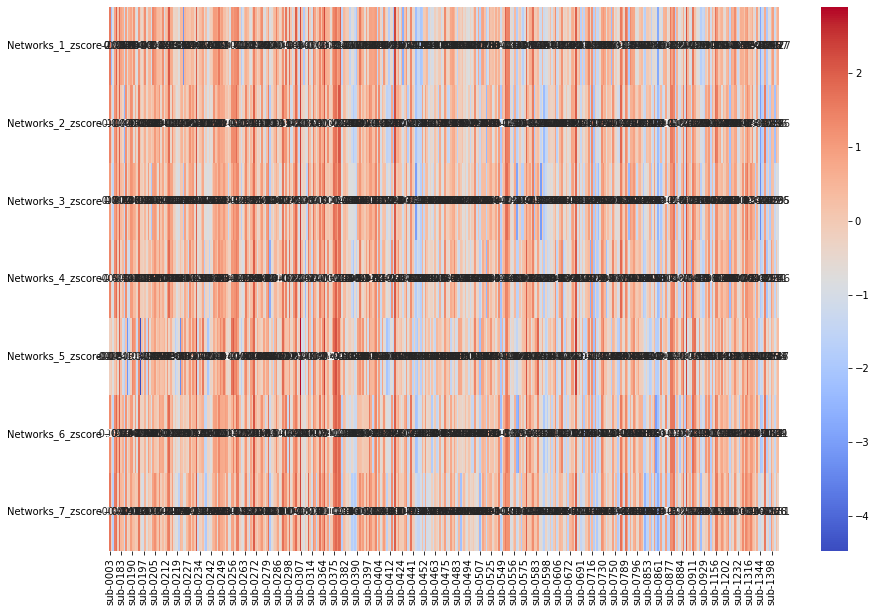

In [225]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_t, annot = True, cmap = 'coolwarm')

In [226]:
print(dict_fw_y)
columns = ['corr', 'sex', 'age_at_first_scan', 'fwd']

{'sub-0003': 0.09664456189654759, 'sub-0070': 0.1489389648802381, 'sub-0095': 0.08825938860119042, 'sub-0096': 0.21970604894999995, 'sub-0114': 0.9413613430952379, 'sub-0132': 0.0565258082142857, 'sub-0182': 0.07089963233602378, 'sub-0183': 0.052684124296428554, 'sub-0184': 0.1368200141904762, 'sub-0185': 0.22186773852083322, 'sub-0186': 0.14609595038095233, 'sub-0187': 0.08279169720390474, 'sub-0188': 0.07766682419047613, 'sub-0189': 0.21299287008333337, 'sub-0190': 0.07589166767857142, 'sub-0191': 0.08552490093428569, 'sub-0192': 0.07549627735214284, 'sub-0193': 0.12458468573869041, 'sub-0194': 0.12420606317476186, 'sub-0195': 0.09995813947619042, 'sub-0196': 0.07797852501190472, 'sub-0197': 0.09096824165238093, 'sub-0198': 0.07001534938142855, 'sub-0199': 0.06817273137619047, 'sub-0201': 0.06508551732142853, 'sub-0202': 0.4559233474690478, 'sub-0203': 0.04851822910095237, 'sub-0204': 0.07510015462857142, 'sub-0205': 0.06972877315714285, 'sub-0206': 0.10124860915476186, 'sub-0207': 0

In [227]:
for y in dict_connectome_y:    
    print (dict_connectome_y[y])
    

[[0.         0.8103658  0.7686732  0.7450342  0.3603352  0.7366579
  0.82835686]
 [0.8103658  0.         0.7688731  0.91583854 0.30068088 0.73323905
  0.80746824]
 [0.7686732  0.7688731  0.         0.72248924 0.22595407 0.85349137
  0.8183684 ]
 [0.7450342  0.91583854 0.72248924 0.         0.38160664 0.76176304
  0.80932415]
 [0.3603352  0.30068088 0.22595407 0.38160664 0.         0.31728107
  0.39220077]
 [0.7366579  0.73323905 0.85349137 0.76176304 0.31728107 0.
  0.86054486]
 [0.82835686 0.80746824 0.8183684  0.80932415 0.39220077 0.86054486
  0.        ]]
[[ 0.          0.09425567  0.5492664  -0.08731915  0.14153121  0.08322944
  -0.14212759]
 [ 0.09425567  0.          0.39922908  0.7746765   0.55523586  0.56449544
   0.5427185 ]
 [ 0.5492664   0.39922908  0.          0.30371362  0.30608654  0.5964501
   0.38682762]
 [-0.08731915  0.7746765   0.30371362  0.          0.4317283   0.57251275
   0.5618133 ]
 [ 0.14153121  0.55523586  0.30608654  0.4317283   0.          0.41070864
   0.

[[0.         0.8860341  0.9182996  0.82240576 0.66822344 0.8289124
  0.8544744 ]
 [0.8860341  0.         0.92050713 0.8704208  0.7338807  0.8240218
  0.86195236]
 [0.9182996  0.92050713 0.         0.85693955 0.70040894 0.83815014
  0.8213423 ]
 [0.82240576 0.8704208  0.85693955 0.         0.63289803 0.91646695
  0.8646987 ]
 [0.66822344 0.7338807  0.70040894 0.63289803 0.         0.62229437
  0.6785596 ]
 [0.8289124  0.8240218  0.83815014 0.91646695 0.62229437 0.
  0.86137486]
 [0.8544744  0.86195236 0.8213423  0.8646987  0.6785596  0.86137486
  0.        ]]
[[0.         0.6326118  0.46250147 0.43103966 0.2940459  0.41287327
  0.5682074 ]
 [0.6326118  0.         0.76892316 0.7944493  0.334638   0.6592086
  0.42298684]
 [0.46250147 0.76892316 0.         0.7448005  0.32576734 0.6629272
  0.28927523]
 [0.43103966 0.7944493  0.7448005  0.         0.30997312 0.73594004
  0.31923905]
 [0.2940459  0.334638   0.32576734 0.30997312 0.         0.41247556
  0.5793406 ]
 [0.41287327 0.6592086  0.6

In [228]:
liste_cases = []
for i in range(len(yeo_2011_labels)):
    new_list = []
    for j in range(len(yeo_2011_labels)):
        data_j = np.zeros(shape=(len(liste_path_y), 4))
        for x in range(len(liste_y)):
            data_j[x][0] = dict_connectome_y[liste_y_comp[x]][i][j]
            if df_participants.loc[liste_y_comp[x], "sex"] == 'F':
                data_j[x][1] = 0
            elif df_participants.loc[liste_y_comp[x], "sex"] == 'M':
                data_j[x][1] = 1
            data_j[x][2] = df_participants.loc[liste_y_comp[x], "age_at_first_scan"]
            data_j[x][3] = dict_fw_y[liste_y_comp[x]]
        
        df_case = pd.DataFrame(data = data_j, index = liste_y_comp, columns = columns)
        
        
        
        new_list.append(df_case)
    liste_cases.append(new_list)

In [229]:
print(liste_cases[0][2])

              corr  sex  age_at_first_scan       fwd
sub-0003  0.768673  0.0                9.4  0.096645
sub-0070  0.549266  1.0                4.4  0.148939
sub-0095  0.302239  0.0               14.5  0.088259
sub-0096  0.615510  1.0                4.9  0.219706
sub-0114  0.820533  1.0               10.0  0.941361
...            ...  ...                ...       ...
sub-1398  0.469929  1.0                5.2  0.790106
sub-1411  0.773813  1.0               15.4  0.148745
sub-1425  0.543858  0.0                2.9  0.103828
sub-1460  0.612125  1.0                6.7  0.098578
sub-1491  0.518330  0.0                8.9  0.156882

[418 rows x 4 columns]


In [230]:
from sklearn.linear_model import LinearRegression

import copy

dict_connectome_residus = copy.deepcopy(dict_connectome_y)

In [231]:
for i in range(len(liste_cases)):
    j = 0
    for df in liste_cases[i]:
        X = df.drop('corr', axis = 1)
        y = df['corr']
        reg = LinearRegression().fit(X, y)
        for sub in dict_connectome_residus:
            val = dict_connectome_residus[sub][i][j]
            dict_connectome_residus[sub][i][j] = val - reg.predict(pd.Series.to_numpy(X.loc[sub]).reshape(1,3))
        j = j+1

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pierre/anaconda3/lib/python3.9/site-packages

In [232]:
dict_connectome_residus

{'sub-0003': array([[ 0.        ,  0.33978802,  0.1721552 ,  0.30648652,  0.04963919,
          0.2894739 ,  0.41153917],
        [ 0.33978802,  0.        ,  0.19482572,  0.21407251, -0.02278087,
          0.27142268,  0.38957953],
        [ 0.1721552 ,  0.19482572,  0.        ,  0.13558793, -0.12716609,
          0.20212424,  0.40020123],
        [ 0.30648652,  0.21407251,  0.13558793,  0.        ,  0.07511044,
          0.19656383,  0.43023485],
        [ 0.04963919, -0.02278087, -0.12716609,  0.07511044,  0.        ,
         -0.06645227, -0.09783663],
        [ 0.2894739 ,  0.27142268,  0.20212424,  0.19656383, -0.06645227,
          0.        ,  0.2592287 ],
        [ 0.41153917,  0.38957953,  0.40020123,  0.43023485, -0.09783663,
          0.2592287 ,  0.        ]], dtype=float32),
 'sub-0070': array([[ 0.0000000e+00, -3.2425529e-01, -4.8724059e-03, -4.9642545e-01,
         -1.6129979e-01, -3.4939480e-01, -5.6897259e-01],
        [-3.2425529e-01,  0.0000000e+00, -1.5177214e-01,  

In [233]:
liste_moyenne = []
for i in dict_connectome_residus:
    new_list = []
    for j in range(len(dict_connectome_residus[i])):
        new_list.append(dict_connectome_residus[i][j].mean())
    liste_moyenne.append(new_list)

In [234]:
columns = dict_connectome_residus.keys()
index = yeo_2011_labels
df = pd.DataFrame(data = liste_moyenne, index = columns, columns = index)
cols = list(df.columns)
for col in cols:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    df = df.drop([col], axis = 1)
df_t = df.T
df_t

sub-0003  sub-0070  sub-0095  sub-0096  sub-0114  sub-0132  \
Networks_1_zscore  1.686277 -2.047522 -0.941920  1.043720  1.575722  0.401579   
Networks_2_zscore  1.529027  0.025359 -1.149455  1.233730  1.021592  0.402220   
Networks_3_zscore  1.113045 -0.602142 -1.537219  1.104368  0.971465  0.626041   
Networks_4_zscore  1.525810 -0.451644 -0.923992  1.345505  1.007031  0.039545   
Networks_5_zscore -0.180763  0.006970 -0.737469  0.074844  0.435803 -0.421401   
Networks_6_zscore  1.334487 -0.111997 -1.558283  1.215979  1.090628  0.720544   
Networks_7_zscore  1.729855 -0.311039 -1.765992  1.468363  0.827188 -0.140166   

                   sub-0182  sub-0183  sub-0184  sub-0185  ...  sub-1354  \
Networks_1_zscore  1.802084  0.805256  0.672513 -1.291800  ... -1.143989   
Networks_2_zscore  2.077057  0.112528 -0.290373 -2.452595  ... -1.479352   
Networks_3_zscore  1.975038  0.355061  0.232174 -1.483980  ... -1.238761   
Networks_4_zscore  2.177376 -0.116342  0.447702 -1.717328  ... -0.654816   
Networks_5_zscore  1.983980  0.343542 -1.123089 -1.678081  ...  0.007216   
Networks_6_zscore  2.235513  0.289733  0.585269 -1.611366  ... -0.736057   
Networks_7_zscore  1.987629  0.710363  0.354118 -1.428698  ... -0.682930   

                   sub-1364  sub-1374  sub-1376  sub-1387  sub-1398  sub-1411  \
Networks_1_zscore  0.193727 -1.876070 -0.353258 -0.750711  0.152778  1.101539   
Networks_2_zscore  0.937038 -1.765834  0.054616 -1.793955 -0.059089  0.374308   
Networks_3_zscore  0.390688 -1.411916 -0.103503 -1.788035 -0.034306  0.371373   
Networks_4_zscore  0.527728 -2.115233 -0.619111 -1.246820  0.302798  0.327914   
Networks_5_zscore  1.142665 -0.465194  0.193960 -0.839493  0.313041  0.097230   
Networks_6_zscore  0.842310 -1.932830  0.046296 -1.190183 -0.038909 -0.131465   
Networks_7_zscore  0.558246 -1.183115 -0.264243 -1.610661  0.252445  0.080683   

                   sub-1425  sub-1460  sub-1491  
Networks_1_zscore -1.157052  0.329957  0.604627  
Networks_2_zscore -2.138343  0.551140 -0.127621  
Networks_3_zscore -1.281544 -0.567797 -0.961603  
Networks_4_zscore -1.448221  0.264821 -0.792525  
Networks_5_zscore -0.920338 -0.128126  0.364739  
Networks_6_zscore -1.482691  0.133525  0.260125  
Networks_7_zscore -1.046098  0.316429 -0.351799  

[7 rows x 418 columns]

<AxesSubplot:>

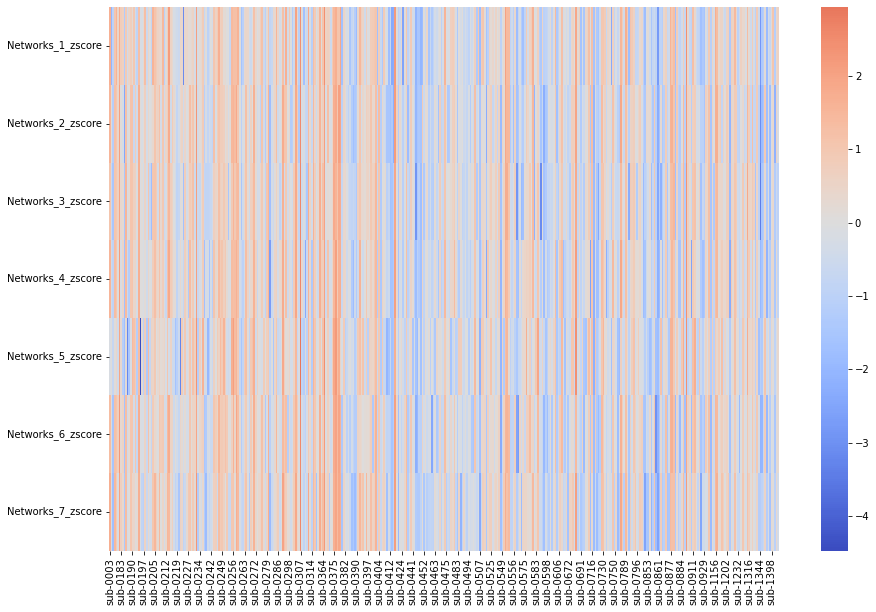

In [235]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_t, cmap = 'coolwarm', center = 0)

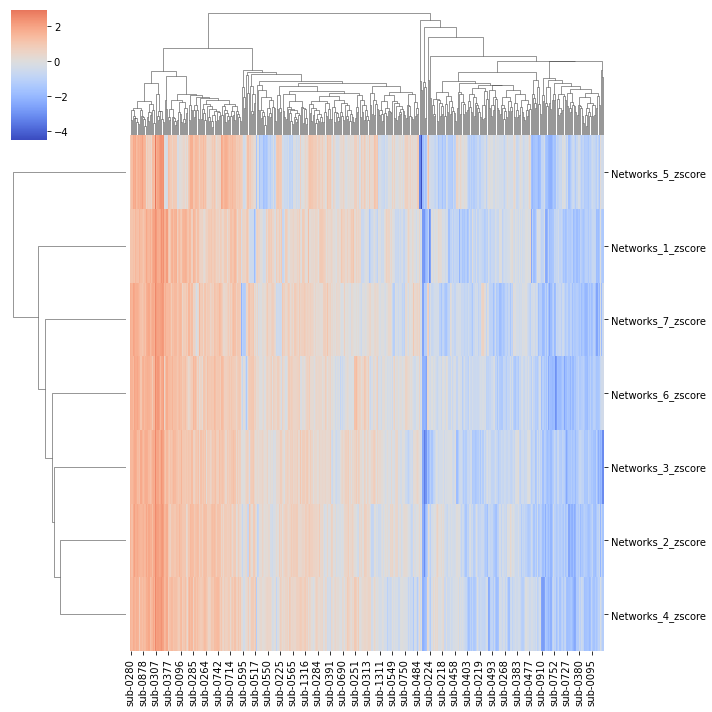

In [236]:
reordered_sub = sns.clustermap(df_t, center = 0, cmap = 'coolwarm').dendrogram_col.reordered_ind

In [237]:
reordered_sub

[99,
 166,
 108,
 143,
 140,
 18,
 79,
 90,
 350,
 398,
 77,
 351,
 127,
 248,
 144,
 131,
 319,
 378,
 379,
 124,
 116,
 247,
 119,
 178,
 6,
 141,
 291,
 360,
 54,
 134,
 264,
 0,
 37,
 142,
 36,
 185,
 209,
 68,
 352,
 80,
 322,
 13,
 95,
 249,
 3,
 10,
 33,
 4,
 110,
 27,
 325,
 28,
 156,
 76,
 358,
 104,
 278,
 282,
 228,
 78,
 301,
 160,
 52,
 289,
 14,
 50,
 85,
 136,
 347,
 188,
 404,
 65,
 168,
 401,
 307,
 374,
 215,
 314,
 31,
 163,
 267,
 365,
 24,
 58,
 260,
 71,
 69,
 327,
 299,
 364,
 308,
 133,
 390,
 233,
 395,
 70,
 128,
 165,
 219,
 270,
 137,
 198,
 164,
 15,
 382,
 109,
 88,
 115,
 340,
 195,
 236,
 12,
 94,
 239,
 297,
 147,
 161,
 337,
 189,
 203,
 213,
 246,
 263,
 8,
 171,
 105,
 332,
 184,
 256,
 232,
 303,
 67,
 47,
 326,
 328,
 362,
 383,
 214,
 241,
 73,
 281,
 361,
 117,
 253,
 381,
 331,
 39,
 385,
 91,
 320,
 98,
 132,
 29,
 386,
 399,
 206,
 243,
 22,
 409,
 238,
 288,
 45,
 380,
 146,
 376,
 103,
 162,
 354,
 112,
 139,
 7,
 157,
 66,
 234,
 158,
 84,


In [238]:
df_t.columns[reordered_sub]

Index(['sub-0280', 'sub-0402', 'sub-0290', 'sub-0378', 'sub-0375', 'sub-0194',
       'sub-0258', 'sub-0271', 'sub-0877', 'sub-1315',
       ...
       'sub-0868', 'sub-0412', 'sub-1387', 'sub-0851', 'sub-0927', 'sub-0791',
       'sub-0855', 'sub-0582', 'sub-0569', 'sub-0594'],
      dtype='object', length=418)

<AxesSubplot:>

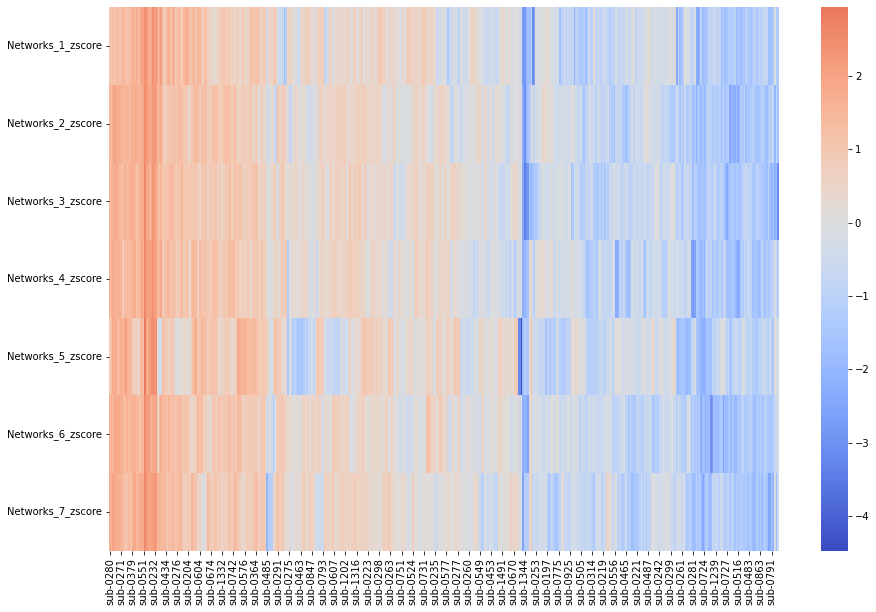

In [239]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_t[df_t.columns[reordered_sub]], center = 0, cmap = 'coolwarm')

In [290]:
ordre = list(df_t.columns[reordered_sub])

In [291]:
def splitage(liste ,k):
    clusts = []
    dict_split = {}
    last = 0
    for i in range(1, k+1):
        dict_split['clust{}'.format(i)]=[]
        for j in range(last, int(len(liste)/k*i)):
            dict_split['clust{}'.format(i)].append(liste[j])
            last = j+1
        clusts.append(dict_split['clust{}'.format(i)])
    return clusts

In [292]:
clusts = splitage(liste = ordre, k = 3)

In [299]:
dict_info_cluster = {}

i=1
for clust in clusts:
    count_f = 0
    count_A = 0
    list_fw = []
    list_age = []
    count_iq = 0
    list_iq = []
    list_dq = []
    count_dq = 0
    
    for sub in clust:
        if df_participants.loc[sub]['sex'] == 'F':
            count_f = count_f+1
        if df_participants.loc[sub]['ASD'] == 'Yes':
            count_A = count_A+1
        list_fw.append(dict_fw_y[sub])
        list_age.append(df_participants.loc[sub]['age_at_first_scan'])
        nb = len(clust)
        if df_participants_complet.loc[sub]['Total_IQ'] != 'n/a':
            count_iq = count_iq +1
            list_iq.append(df_participants_complet.loc[sub]['Total_IQ'])
            
    list_iq = list(map(int, list_iq))
    list_dq = list(map(int, list_dq))
    
    dict_info_cluster["clust{}".format(i)] = {}
    dict_info_cluster["clust{}".format(i)]['n'] = nb
    dict_info_cluster["clust{}".format(i)]['%femme'] = (count_f/nb)*100
    dict_info_cluster["clust{}".format(i)]['%ASD(n)'] = "{}({})".format((count_A/nb)*100, count_A)
    dict_info_cluster["clust{}".format(i)]['mean_age(sd)'] = "{}({})".format(round(np.mean(list_age), 4), round(np.std(list_age), 4))
    dict_info_cluster["clust{}".format(i)]['mean_fwd(sd)'] = "{}({})".format(round(np.mean(list_fw), 4), round(np.std(list_fw), 4))
    dict_info_cluster["clust{}".format(i)]['total_IQ(mean/sd/n)'] = "{}/{}/{}".format(round(np.mean(list_iq), 4), round(np.std(list_iq), 4), len(list_iq))
    i = i+1
        

In [300]:
dict_info_cluster

{'clust1': {'n': 139,
  '%femme': 47.482014388489205,
  '%ASD(n)': '23.021582733812952(32)',
  'mean_age(sd)': '26.5058(16.0895)',
  'mean_fwd(sd)': '0.1758(0.1787)',
  'total_IQ(mean/sd/n)': '102.3824/23.7252/34'},
 'clust2': {'n': 139,
  '%femme': 47.482014388489205,
  '%ASD(n)': '28.776978417266186(40)',
  'mean_age(sd)': '27.8158(16.6067)',
  'mean_fwd(sd)': '0.189(0.2482)',
  'total_IQ(mean/sd/n)': '107.2222/21.1105/27'},
 'clust3': {'n': 140,
  '%femme': 46.42857142857143,
  '%ASD(n)': '32.142857142857146(45)',
  'mean_age(sd)': '27.1807(16.986)',
  'mean_fwd(sd)': '0.1629(0.3018)',
  'total_IQ(mean/sd/n)': '99.2333/27.8923/30'}}

In [301]:
pd.DataFrame.from_dict(dict_info_cluster)

clust1                  clust2  \
n                                       139                     139   
%femme                            47.482014               47.482014   
%ASD(n)              23.021582733812952(32)  28.776978417266186(40)   
mean_age(sd)               26.5058(16.0895)        27.8158(16.6067)   
mean_fwd(sd)                 0.1758(0.1787)           0.189(0.2482)   
total_IQ(mean/sd/n)     102.3824/23.7252/34     107.2222/21.1105/27   

                                     clust3  
n                                       140  
%femme                            46.428571  
%ASD(n)              32.142857142857146(45)  
mean_age(sd)                27.1807(16.986)  
mean_fwd(sd)                 0.1629(0.3018)  
total_IQ(mean/sd/n)      99.2333/27.8923/30